In [1]:
import os
from os import listdir
from os.path import isfile, join
dir_files = [i for i in os.listdir(os.getcwd() + '/data') if os.path.isfile(join(os.getcwd() + '/data', i))]
dir_files

['2year.arff', '3year.arff', '5year.arff', '4year.arff', '1year.arff']

In [2]:
from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
#combine all the files
data_dict = {}
full_df = pd.DataFrame()

records = 0

for f in dir_files:
    temp_data = arff.loadarff(os.getcwd() + '/data/' +f)
    temp_df = pd.DataFrame(temp_data[0])
    print(temp_df.shape)
    data_dict.update({f:temp_df})
    full_df = pd.concat([full_df, temp_df])
    records += temp_df.shape[0]

print(records)

(10173, 65)
(10503, 65)
(5910, 65)
(9792, 65)
(7027, 65)
43405


In [4]:
full_df.reset_index(inplace=True,drop=True)

In [5]:
missing_vals = full_df.isna().sum()
missing_vals = pd.DataFrame(missing_vals,columns=['missing'])
missing_vals = missing_vals.sort_values(by = ['missing'],ascending=False)
missing_vals.reset_index()

,index,missing
0,Attr37,18984
1,Attr21,5854
2,Attr27,2764
3,Attr60,2152
4,Attr45,2147
...,...,...
60,Attr10,8
61,Attr57,7
62,Attr59,7
63,Attr55,1


Text(0, 0.5, 'Attributes')

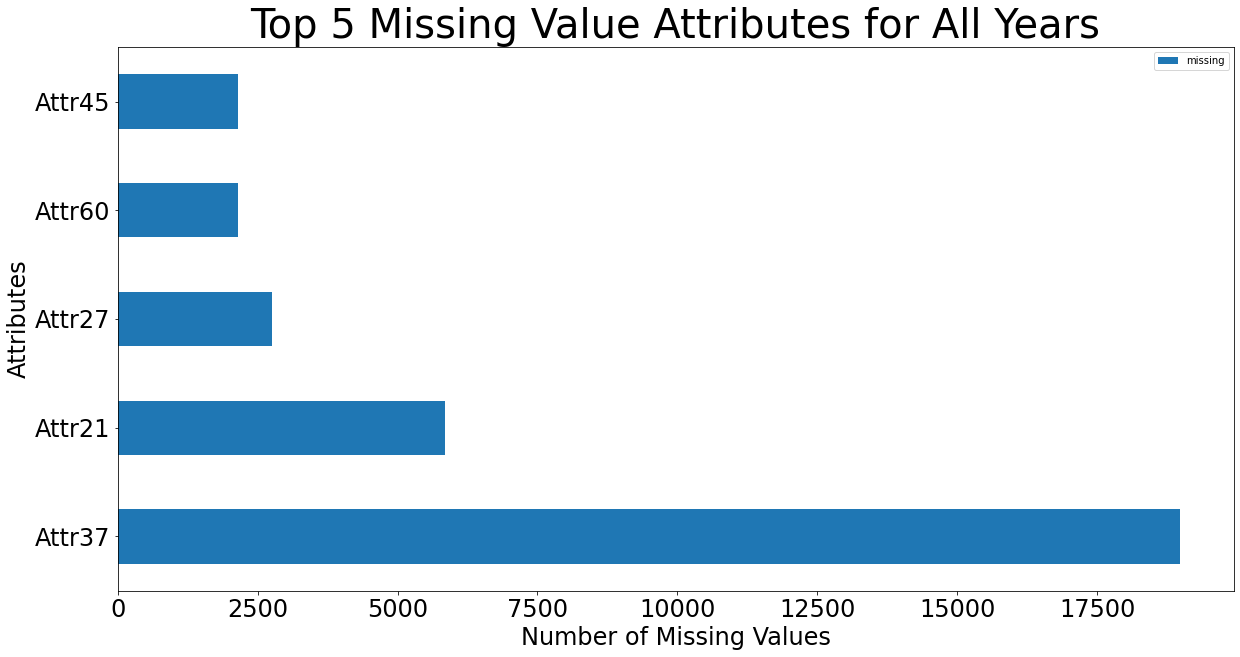

In [6]:
top_five_missing  = missing_vals.head(5)
ax = top_five_missing.plot.barh(title = 'Top 5 Missing Value Attributes for All Years'
,figsize = (20,10),fontsize=24)
ax.title.set_size(40)
ax.set_xlabel('Number of Missing Values',fontsize = 24)
ax.set_ylabel('Attributes',fontsize = 24)


In [7]:
full_df['class'].value_counts()

b'0'    41314
b'1'     2091
Name: class, dtype: int64

In [8]:
41314/43405

0.9518258265176823

In [9]:
classes = []
uniqueClass = full_df['class'].unique()
classes.append(uniqueClass[0])
classes.append(uniqueClass[1])
classes

[b'0', b'1']

In [10]:
class_dict = {}

for index, i in enumerate(classes):
    class_dict.update({i:index})

class_dict

{b'0': 0, b'1': 1}

In [11]:
full_df['class'] = full_df['class'].map(class_dict)

# Random Forest base model no cv to get feature importance

In [12]:
full_df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

In [13]:
full_df.isna().sum()

Attr1       8
Attr2       8
Attr3       8
Attr4     134
Attr5      89
         ... 
Attr61    102
Attr62    127
Attr63    134
Attr64    812
class       0
Length: 65, dtype: int64

In [14]:
# X = full_df.loc[:, full_df.columns != 'class'].values
# y = full_df['class'].values

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 58)

In [15]:
X = full_df.drop("class", axis=1).copy()
y = full_df['class'].values

In [16]:
X.columns

Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43',
       'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57',
       'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64'],
      dtype='object')

In [17]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
X_imp = imp_mean.fit_transform(X)

X_imp_df = pd.DataFrame(X_imp, columns=imp_mean.feature_names_in_)


In [18]:
from sklearn.preprocessing import StandardScaler
stdsclr = StandardScaler()
X_imp_scaled  = stdsclr.fit_transform(X_imp_df)

In [18]:
rf_clf1 = RandomForestClassifier(random_state = 58)
rf_clf1.fit(X_train, y_train)
rf_clf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 58,
 'verbose': 0,
 'warm_start': False}

In [19]:
y_hat_rf_test1 = rf_clf1.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_rf_test1))
print("\n Classification Report \n",classification_report(y_test, y_hat_rf_test1, digits=6))

Confusion Matrix 
 [[10301    30]
 [  358   163]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.966413  0.997096  0.981515     10331
           1   0.844560  0.312860  0.456583       521

    accuracy                       0.964246     10852
   macro avg   0.905486  0.654978  0.719049     10852
weighted avg   0.960563  0.964246  0.956313     10852



# Feature Importance

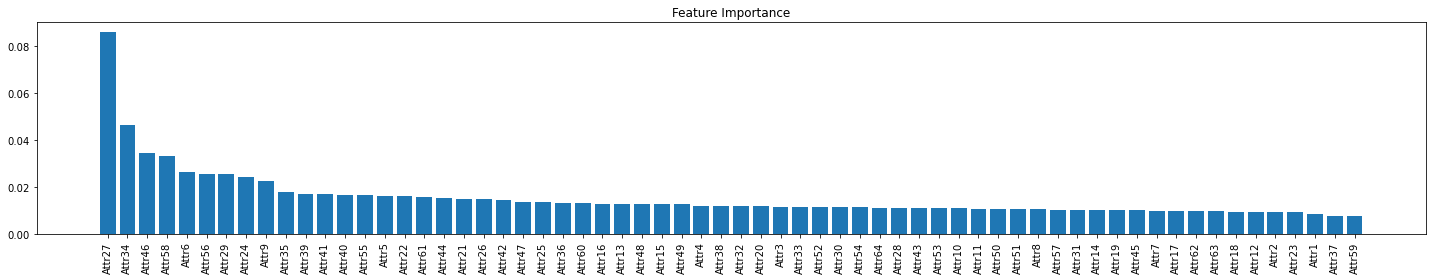

In [20]:
feature_importances = rf_clf1.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(20,4))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Random Forest Gridsearch


In [38]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
cv_grid = StratifiedKFold(n_splits=10,random_state=58, shuffle=True)
# cv_grid = KFold(n_splits=10, shuffle=True,random_state=58)

In [75]:
from sklearn.metrics import make_scorer, log_loss
logloss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [76]:
from sklearn.model_selection import cross_validate

def InjuryEvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

In [86]:
rf_clf2 = RandomForestClassifier(random_state=58)
param_grid = { 
    'n_estimators': [35,40,45],
    'max_features': ['auto'],
    'max_depth' : [20],
    'class_weight' : [None]
}
CV_rfc = GridSearchCV(estimator=rf_clf2, param_grid=param_grid, cv=cv_grid, n_jobs=2,scoring=logloss_scorer)
CV_rfc.fit(X_imp_scaled, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=58, shuffle=True),
             estimator=RandomForestClassifier(random_state=58), n_jobs=2,
             param_grid={'class_weight': [None], 'max_depth': [20],
                         'max_features': ['auto'],
                         'n_estimators': [35, 40, 45]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [87]:
best_model = CV_rfc.best_params_
CV_rfc.best_params_

{'class_weight': None,
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 45}

In [88]:
CV_rfc.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=45, random_state=58)

In [89]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(CV_rfc.best_estimator_, X_imp_scaled, y, cv=cv_grid, n_jobs=2)

In [90]:
conf_mat = confusion_matrix(y, y_pred)
cl_report = classification_report(y, y_pred, digits=6)

In [91]:
conf_mat

array([[41202,   112],
       [ 1355,   736]])

In [92]:
print("\n Classification Report \n",cl_report)


 Classification Report 
               precision    recall  f1-score   support

           0   0.968160  0.997289  0.982509     41314
           1   0.867925  0.351985  0.500851      2091

    accuracy                       0.966202     43405
   macro avg   0.918042  0.674637  0.741680     43405
weighted avg   0.963332  0.966202  0.959305     43405



In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_imp_scaled,y)

dtrain = xgb.DMatrix(X_train,label=y_train)

dtest = xgb.DMatrix(X_test,label=y_test)

evallist = [(dtest,'eval'), (dtrain,'train')]

In [95]:
param = {'max_depth': 50,
         'objective' : 'binary:logistic',
         'eval_metric' :'logloss',
         'eta': 0.03
        }

In [96]:
bst_cv = xgb.cv(params=param, dtrain=dtrain, nfold=5,num_boost_round = 1000, early_stopping_rounds=5)

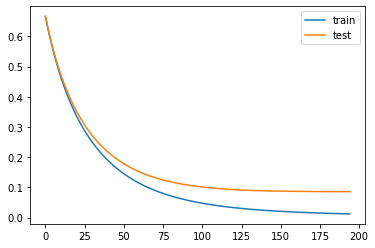

In [97]:
import matplotlib.pyplot as plt
plt.plot(bst_cv.index, bst_cv['train-logloss-mean'],label='train')
plt.plot(bst_cv.index, bst_cv['test-logloss-mean'],label='test')
plt.legend()
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42, use_label_encoder = False,
)
parameters = {
   'max_depth': range (10, 15,1),
    'n_estimators': range(60, 140, 40),
    'learning_rate': [0.1, 0.01, 0.05]
    
}
fit_params = {
'error': 'logloss',
'eval_set': [(X_imp_scaled,y)]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 2,
    cv = cv_grid,
    verbose=True,
    
)
grid_search.fit(X_imp_scaled,y,**fit_params,early_stopping_rounds = 50)

In [ ]:
grid_search.best_estimator_

In [142]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred_xgb = cross_val_predict(grid_search.best_estimator_, X_imp_scaled, y, cv=cv_grid, n_jobs=2)

In [143]:
conf_mat_xgb = confusion_matrix(y, y_pred_xgb)
cl_report_xgb = classification_report(y, y_pred_xgb, digits=6)

In [130]:
print(cl_report_xgb)

              precision    recall  f1-score   support

           0   0.974289  0.997918  0.985962     41314
           1   0.921028  0.479675  0.630818      2091

    accuracy                       0.972952     43405
   macro avg   0.947659  0.738797  0.808390     43405
weighted avg   0.971723  0.972952  0.968853     43405



In [ ]:

# fit_params={"early_stopping_rounds":42, 
#             "eval_metric" : "mae", 
#             "eval_set" : [[testX, testY]]}